# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откроем файл с данными и изучим общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
pd.set_option('display.max_columns', None)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

В датасете 22 столбца: 3 из них типа int, 2 имеют булевые значения, 3 типа object и остальные float.

Построим общую гистограмму для всех числовых столбцов таблицы:

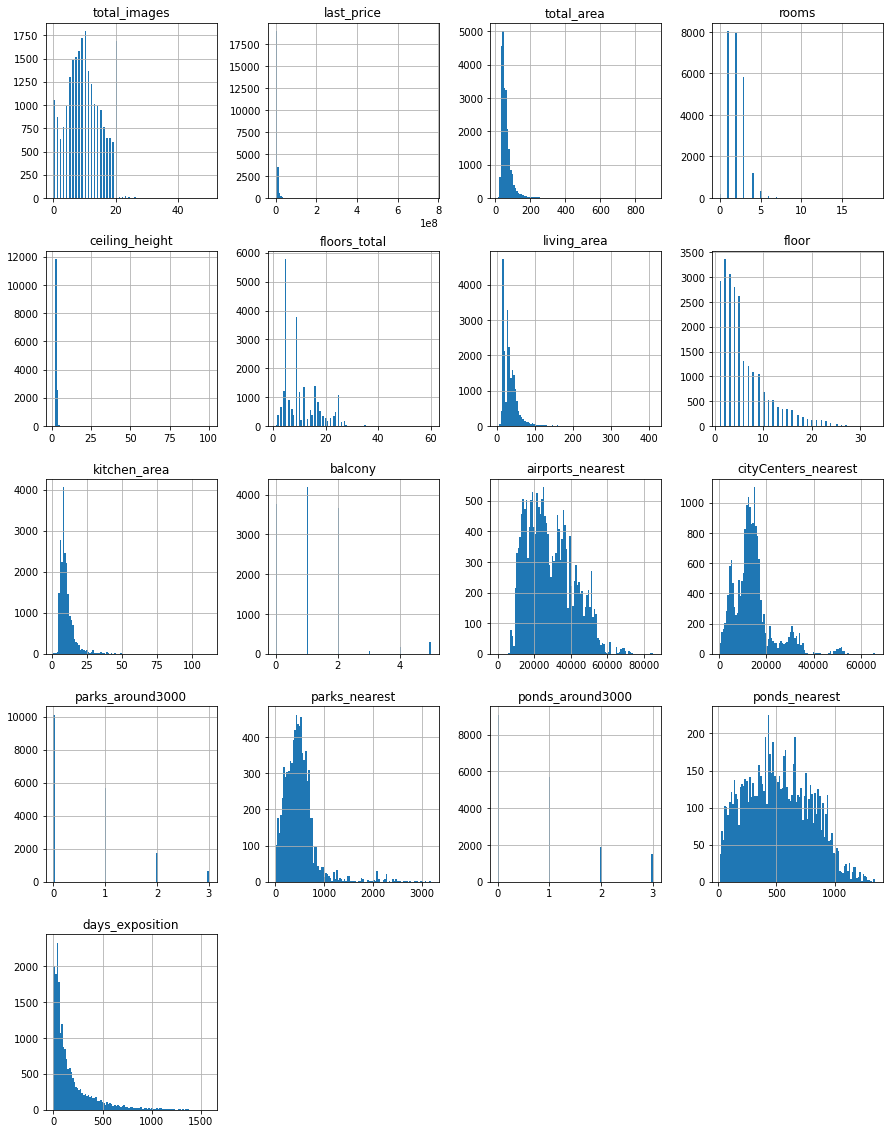

In [3]:
data.hist(bins=100, figsize=(15, 20));

По получившимся гистограммам мы можем получить общее впечатление о данных, к примеру:
* к объявлениям чаще всего подгружают около 8-20 фото
* основной массив данных по количеству комнат - это 1, 2, 3 комнатные квартиры
* в приближенным Пуассону распредлены ближайшие точки инфраструктуры: расстояния до водоема, центра, аэропорта, парка. У каждой гистограммы есть выбивающиеся значения - пики. В графике с расстоянием до центра или ближайшего аэропорта это могут быть густонаселенные районы, районные города. Вблизи с парками и водоемами - масштабные жилые комплексы. 
* Не ясна природа пиков в общей этажности здания, есть гипотеза, что это типовые многоэтажки 5, 9, 12 и тд этажей. Проверим при детальном анализе.
* цена на гистограмме отражается нечитаемо, сократим ее далее на 1000, чтобы данные были более удобны для визуального анализа.

Проверим пустые значения.

In [4]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

#### Вывод

Пропущенные значения были выявлены в следующих столбцах: 
* ceiling_height — высота потолков (м)
* floors_total — всего этажей в доме
* living_area — жилая площадь в квадратных метрах (м²)
* is_apartment — апартаменты (булев тип)
* kitchen_area — площадь кухни в квадратных метрах (м²)
* balcony — число балконов
* locality_name — название населённого пункта
* airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
* cityCenters_nearest — расстояние до центра города (м)
* parks_around3000 — число парков в радиусе 3 км
* parks_nearest — расстояние до ближайшего парка (м)
* ponds_around3000 — число водоёмов в радиусе 3 км
* ponds_nearest — расстояние до ближайшего водоёма (м)
* days_exposition — сколько дней было размещено объявление (от публикации до снятия)

Имеем пропущенные типы данных: добавленные пользователем, картографические и системные (кол-во дней размещения объявления). К первому типу относятся высота потолков, всего этажей в доме, жилая площадь и площадь кухни, статус апартаментов, число балконов, этаж квартиры, ко второму — расстояния до центра города, аэропорта, ближайшего парка их количество, к третьему - кол-во дней размещения объявления. 

Если пропуски третьего типа похожи на технический сбой, или появление их из-за снятия объявления в тот же день, то пропущенные значения в добавленных пользователем данных могут появиться еще и из-за человеческого фактора: невнимательность, нежелание указывать данные с целью утаить понижающие стоимость жилья, а также по незнанию этих данных. 

Пропуски в картографических типах данных скорее всего появились из-за отсутствия данных в системе, либо ошибки при сборе данных либо их выгрузке.

### Предобработка данных

#### Изучим столбец с данными в количественной переменной высоты потолков (ceiling_height).

In [5]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Высокое максимальное значение 100 и большое стандартное отклонение заставляет покапаться глубже в значениях столбца.

In [6]:
data['ceiling_height'].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

Скорректируем сомнительные значения и пометим выбивающиеся как отсутсвтующие:

In [7]:
data['ceiling_height'] = data['ceiling_height'].astype('str')
data.loc[data['ceiling_height'] == '25.0', 'ceiling_height'] = '2.5'
data.loc[data['ceiling_height'] == '100.0', 'ceiling_height'] = 'nan'
data.loc[data['ceiling_height'] == '1.0', 'ceiling_height'] = 'nan'
data.loc[data['ceiling_height'] == '32.0', 'ceiling_height'] = '3.2'
data.loc[data['ceiling_height'] == '27.0', 'ceiling_height'] = '2.7'
data.loc[data['ceiling_height'] == '24.0', 'ceiling_height'] = '2.4'
data.loc[data['ceiling_height'] == '26.0', 'ceiling_height'] = '2.6'
data.loc[data['ceiling_height'] == '1.2', 'ceiling_height'] = 'nan'
data.loc[data['ceiling_height'] == '20.0', 'ceiling_height'] = '2.0'
data.loc[data['ceiling_height'] == '22.6', 'ceiling_height'] = '2.26'
data.loc[data['ceiling_height'] == '27.5', 'ceiling_height'] = '2.75'
data.loc[data['ceiling_height'] == '14.0', 'ceiling_height'] = 'nan'

Еще раз выведем уникальные значения:

In [8]:
data['ceiling_height'].unique()

array(['2.7', 'nan', '3.03', '2.5', '2.67', '2.56', '3.05', '2.75', '2.6',
       '2.9', '2.8', '2.55', '3.0', '2.65', '3.2', '2.61', '3.25', '3.45',
       '2.77', '2.85', '2.64', '2.57', '4.15', '3.5', '3.3', '2.71',
       '4.0', '2.47', '2.73', '2.84', '3.1', '2.34', '3.4', '3.06',
       '2.72', '2.54', '2.51', '2.78', '2.76', '2.58', '3.7', '2.52',
       '5.2', '2.87', '2.66', '2.59', '2.0', '2.45', '3.6', '2.92',
       '3.11', '3.13', '3.8', '3.15', '3.55', '3.16', '3.62', '3.12',
       '2.53', '2.74', '2.96', '2.46', '5.3', '5.0', '2.79', '2.95',
       '4.06', '2.94', '3.82', '3.54', '3.53', '2.83', '4.7', '2.4',
       '3.38', '3.01', '5.6', '3.65', '3.9', '3.18', '3.35', '2.3',
       '3.57', '2.48', '2.62', '2.82', '3.98', '2.63', '3.83', '3.52',
       '3.95', '3.75', '2.88', '3.67', '3.87', '3.66', '3.85', '3.86',
       '4.19', '3.24', '4.8', '4.5', '4.2', '3.36', '3.08', '3.68',
       '3.07', '3.37', '3.09', '8.0', '3.26', '3.34', '2.81', '3.44',
       '2.97', '3.1

Мы избавились от некорректных значений, заменив их, а некоторые изменили на NaN в связи с чем стобец перешел в тип object. Теперь можем перевести столбец обратно в тип float и вывести числовое описание колонки для оценки данных.

In [9]:
data['ceiling_height'] = data['ceiling_height'].astype('float')
data['ceiling_height'].describe()

count    14500.000000
mean         2.728554
std          0.299261
min          1.750000
25%          2.510000
50%          2.650000
75%          2.800000
max         10.300000
Name: ceiling_height, dtype: float64

Скорректировав данные, мы уменьшили стандартное отклонение с 1.26 до 0.29. Максимальная высота потолка теперь не 100 метров, а 10.3, что тоже много, но, допустим, это пентхаус... 
Медиана и среднее значение выглядят разумно, как и значения первого и третьего квартиля.

Как мы выявили ранее, в столбце со занчением высоты потолков 9195 пропущенных значений. Заменить их усредненными или другими не представляется возможным, тк дальнейший расчет взаимосвязи переменных с этим значением будет некорректным.

Посмотрим как выглядят гистограммы по имеющимся данным:

<AxesSubplot:>

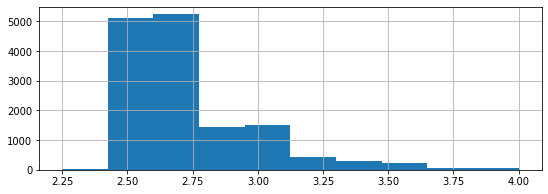

In [10]:
data['ceiling_height'].hist(bins=10, figsize=(9,3), range=(2.25, 4))

Предполагается, что пики массива - это стандартные значения высоты потолков у типовых застройщиков. Аномальных пиков после 3 метров нет.

(2.0, 4.0)

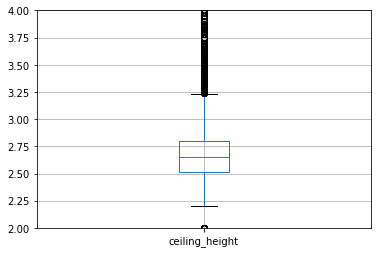

In [11]:
import matplotlib.pyplot as plt
data.boxplot(column='ceiling_height')
plt.ylim(2, 4)  # увеличу ящик с усами, чтобы подробнее разглядеть данные

Основной массив данных колонки о высоте потолков - от 2.25 м до 3.25 м. 

Мы имеем незначительную часть выбросов меньше значения 2.25 м и значительную часть выбросов больше значения 3.25 м. Проверим, сколько строк с высотой потолка выше 2.9 м

In [12]:
data[data['ceiling_height'] > 3.25]['ceiling_height'].count()

743

Это больша'я часть строк с реальными данными, отбросить ее мы не можем. Оставляем для дальнейшего анализа.

#### Изучим столбец с данными количества этажей в доме (floors_total).

Построим гистограмму по столбцу, чтобы визуально оценить значения:

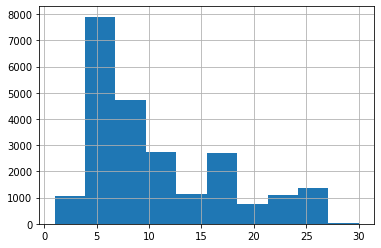

In [13]:
data['floors_total'].hist(bins=10, range=(1,30));

Основные пики выделены типовыми многоэтажками: 5, 9, 12, 16 и тд по нормам строительства.

Еще раз выведем количество пустых значений.

In [14]:
data['floors_total'].isna().sum()

86

In [15]:
data = data.dropna(subset=['floors_total'])

Всего 86 строк. Избавимся от них, чтобы оставить корректные значения.

#### Изучим столбец с данными жилой площади (living_area).

In [16]:
data['living_area'].describe()  # выведем описание столбца

count    21743.000000
mean        34.462781
std         22.037433
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

Значение, которое меня смущает - это минимальная жилая площадь. Выведу на экран число строк, с жилой площадью до 8 кв м (экстремально маленькие).

In [17]:
data[data['living_area'] < 8 ]['living_area'].count()

8

In [18]:
data[data['living_area'] < 8]  # рассмотрим детельнее каждую

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3242,7,4440000.0,41.0,2017-07-02T00:00:00,1,NaN,17.0,3.0,17,NaN,False,False,11.0,NaN,Санкт-Петербург,19272.0,13073.0,0.0,NaN,0.0,NaN,216.0
13915,20,6350000.0,52.0,2018-02-06T00:00:00,2,3.0,6.0,2.0,2,NaN,False,False,9.0,NaN,Санкт-Петербург,32453.0,6521.0,0.0,NaN,1.0,1012.0,91.0
16431,13,3799000.0,31.0,2018-04-12T00:00:00,1,2.6,5.0,6.0,1,NaN,False,False,17.0,NaN,Санкт-Петербург,32177.0,4826.0,1.0,430.0,0.0,NaN,168.0
17582,11,2680000.0,22.0,2018-08-11T00:00:00,0,NaN,25.0,5.0,8,NaN,True,False,NaN,2.0,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,70.0
19251,19,4050000.0,33.0,2018-10-15T00:00:00,1,2.5,22.0,6.5,21,NaN,False,False,18.0,NaN,Санкт-Петербург,9258.0,10592.0,1.0,458.0,0.0,NaN,44.0
21758,0,2330000.0,23.0,2018-01-01T00:00:00,0,NaN,24.0,2.0,22,NaN,True,False,NaN,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,66.0
21943,15,6100000.0,77.6,2019-02-28T00:00:00,4,2.5,9.0,5.4,1,NaN,False,False,9.8,NaN,Санкт-Петербург,29338.0,11270.0,1.0,584.0,0.0,NaN,33.0
23574,14,64990000.0,139.0,2015-11-24T00:00:00,3,3.0,8.0,3.0,8,NaN,False,False,16.0,1.0,Санкт-Петербург,33255.0,5975.0,1.0,630.0,3.0,100.0,280.0


Очевидно, где общая площадь 139 кв м, сложно представить жилую 3. Также сложно представить жилую площадь 2 кв м в квартирах, с общей площадью 52. Всего 8 строчек с подобными значениями, заменим их на медианные.

In [19]:
data.loc[data['living_area'] < 8, 'living_area'] = data['living_area'].median()

In [20]:
data['living_area'].isna().sum() # выведем кол-во пустых значений

1870

Оставлю пустые строчки, тк их отсутствие может повлиять на корректность исследования. 

#### Изучим столбец с данными количества балконов  (balcony).

In [21]:
data['balcony'].isna().sum()  # выведем еще раз пропущенные значения

11480

In [22]:
data['balcony'].value_counts()  # посчитаем уникальные значения

1.0    4195
0.0    3713
2.0    3657
5.0     304
4.0     183
3.0      81
Name: balcony, dtype: int64

Предполагая, что отсутствующие значения - это квартиры с отсутствующими балконами, заменим пустые значения числом 0, и изменим тип данных на int, тк числа в столбце целые.

In [23]:
data['balcony'] = data['balcony'].fillna(0) 
data['balcony'] = data['balcony'].astype('int')

#### Изучим столбец с данными статуса апартаментов (is_apartment).

Выведем уникальные значения

In [24]:
data['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

Данные буллевого типа. Оставим пропущенные значения, тк в исследовании нет задачи связанной с этим столбцом.

#### Изучим столбец с данными площади кухни (kitchen_area).

In [25]:
data['kitchen_area'].describe()

count    21382.000000
mean        10.564128
std          5.904316
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

Настораживает максимальное значение в столбце - 112 кв м. Проверим сколько значений больше 50 кв м (очень большие кухни).

In [26]:
data[data['kitchen_area'] > 50][['kitchen_area']].count()

kitchen_area    46
dtype: int64

In [27]:
data[data['kitchen_area'] > 50]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
492,18,95000000.0,216.0,2017-12-05T00:00:00,4,3.00,5.0,86.00,4,NaN,False,False,77.0,0,Санкт-Петербург,21740.0,436.0,2.0,138.0,3.0,620.0,14.0
1026,20,155000000.0,310.0,2018-10-12T00:00:00,5,5.30,3.0,190.00,3,NaN,False,False,63.0,2,Санкт-Петербург,24899.0,4785.0,0.0,NaN,1.0,603.0,NaN
1085,16,75000000.0,323.0,2017-07-10T00:00:00,5,4.00,5.0,255.70,4,NaN,False,False,66.0,0,Санкт-Петербург,23713.0,594.0,3.0,398.0,2.0,515.0,259.0
2489,9,12500000.0,255.0,2017-04-21T00:00:00,3,NaN,2.0,153.90,2,NaN,False,False,100.7,0,Санкт-Петербург,29544.0,6916.0,0.0,NaN,3.0,198.0,102.0
3117,19,140000000.0,631.0,2019-03-30T00:00:00,7,NaN,5.0,NaN,5,NaN,False,False,60.0,0,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN
3561,5,12300000.0,115.0,2017-08-09T00:00:00,3,2.70,20.0,45.00,16,NaN,False,False,60.0,1,Санкт-Петербург,33386.0,14234.0,0.0,NaN,0.0,NaN,63.0
4320,20,19700000.0,146.3,2017-02-10T00:00:00,3,3.40,6.0,55.80,6,NaN,False,False,56.2,0,Санкт-Петербург,23312.0,2450.0,1.0,548.0,3.0,883.0,638.0
4394,20,57000000.0,174.0,2015-11-09T00:00:00,3,3.20,10.0,95.00,6,NaN,False,False,77.0,0,Санкт-Петербург,31706.0,4166.0,1.0,193.0,3.0,199.0,1039.0
5358,20,65000000.0,590.0,2019-02-14T00:00:00,15,3.50,6.0,409.00,3,NaN,False,False,100.0,0,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0
6021,19,16830000.0,117.4,2019-04-04T00:00:00,2,2.75,16.0,33.40,13,NaN,False,False,51.0,2,Санкт-Петербург,51030.0,14721.0,0.0,NaN,0.0,NaN,NaN


Судя по общей жилой площади, такие кухни располагаются в частных домах. 

Выведу теперь строки с пустыми значениями кухни. И ознакомлюсь со значениями общей площади таких квартир.

In [28]:
data.query('kitchen_area.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
30,12,2200000.0,32.8,2018-02-19T00:00:00,1,NaN,9.0,NaN,2,NaN,False,False,NaN,0,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0
37,10,1990000.0,45.8,2017-10-28T00:00:00,2,2.50,5.0,NaN,1,NaN,False,False,NaN,0,поселок городского типа Красный Бор,NaN,NaN,NaN,NaN,NaN,NaN,196.0
44,13,5350000.0,40.0,2018-11-18T00:00:00,1,NaN,22.0,NaN,3,NaN,False,False,NaN,1,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN
59,15,6300000.0,46.5,2017-03-06T00:00:00,1,NaN,13.0,NaN,13,NaN,False,False,NaN,0,Санкт-Петербург,11125.0,14501.0,0.0,NaN,0.0,NaN,336.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23655,1,2414306.0,40.5,2016-09-08T00:00:00,1,2.56,18.0,19.6,10,False,False,False,NaN,0,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,627.0
23663,12,6400000.0,88.0,2018-01-12T00:00:00,4,2.55,10.0,NaN,1,NaN,False,False,NaN,0,Санкт-Петербург,33642.0,13943.0,0.0,NaN,2.0,844.0,59.0
23670,9,2450000.0,45.6,2018-02-08T00:00:00,1,2.80,9.0,NaN,2,NaN,False,False,NaN,0,поселок городского типа Синявино,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23679,0,2500000.0,35.0,2017-12-08T00:00:00,1,NaN,9.0,NaN,4,NaN,False,False,NaN,0,Сосновый Бор,NaN,NaN,NaN,NaN,NaN,NaN,45.0


Площадь большая, и кухня там скорее всего есть. 
Отмена -> Заменю пустые значения на медианные.

In [29]:
# data['kitchen_area'] = data['kitchen_area'].fillna(value=data['kitchen_area'].median())

In [30]:
data['kitchen_area'].isna().sum()  # проверим отсутствие пустых значений

2231

Построим гистограмму для оценки основного массива данных.

<AxesSubplot:>

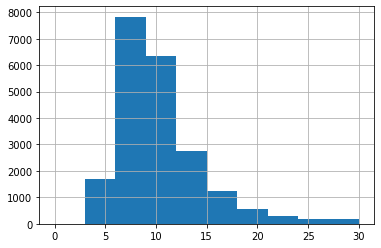

In [31]:
data['kitchen_area'].hist(bins=10, range=(0, 30))

Данные выглядят корректно и распределены в рамках Пуассона.

#### Изучим столбец с данными названий локейта (locality_name).

In [32]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [33]:
data['locality_name'].nunique() # посчитаем количество уникальных

364

«Поселок Рябово» и «поселок городского типа Рябово», «поселок Тельмана» и «посёлок Тельмана» — это обозначения одних и тех же населённых пунктов. Избавимся от дублей. Для начала приведем все значения к строчноым и заменим все "ё" на "е".

In [34]:
data['locality_name'] = data['locality_name'].str.lower()
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')

In [35]:
data['locality_name'].nunique() # посчитаем количество уникальных теперь

330

Мы избавились от 34 дублей. Теперь обработаем неявные дубликаты.

In [36]:
data.loc[data['locality_name'] == 'поселок городского типа рябово', 'locality_name'] = 'поселок рябово'

In [37]:
data['locality_name'].nunique() # посчитаем количество уникальных теперь

329

Осталось избавиться от пропущенных значений, тк восстановить их логику мы не сможем.

In [38]:
data = data.dropna(subset=['locality_name'])

Отлично. Теперь данные выглядят корректно.

#### Изучим столбец со стоимостью (last_price).

In [39]:
data['last_price'].isna().sum()

0

Пропущенных значений нет. 
Сокращу значения на 1000, чтобы было удобнее читать и оставлю 3 знака после запятой.
Выведу описание столбца.

In [40]:
data['last_price'] = round(data['last_price'] / 1000, 3)

In [41]:
data['last_price'].describe()

count     23565.000000
mean       6540.058260
std       10910.934722
min          12.190000
25%        3400.000000
50%        4646.000000
75%        6790.000000
max      763000.000000
Name: last_price, dtype: float64

Меня смущает слишком малая стоимость жилья и слишком высокая. Проверим визуально корректность таких строк, выгрузив строки с минимальной стоимостью до 300 тысяч рублей и максимальной более 200 миллионов.

In [42]:
data[data['last_price'] < 300]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
8793,7,12.19,109.0,2019-03-20T00:00:00,2,2.75,25.0,32.0,25,NaN,False,False,40.5,0,санкт-петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0


In [43]:
data[data['last_price'] > 200]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.00,0,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.00,2,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.30,0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.00,0,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700.0,133.81,2017-03-21T00:00:00,3,3.70,5.0,73.3,3,NaN,False,False,13.83,0,санкт-петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,NaN,False,False,8.50,0,тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,NaN,False,False,NaN,0,село рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475.0,76.75,2017-03-28T00:00:00,2,3.00,17.0,NaN,12,NaN,False,False,23.30,2,санкт-петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0


Строки со стоимостью жилья более 200 миллионов выглядят корректно тк жилье большой площади около центра Санкт-Петербурга.
Строчка с минимальной стоимостью выглядит некорректно. Квартира в Спб площадью 109 кв м не может соить таких денег.
Удаляем строчку под индексом 8793.

In [44]:
data = data.drop(index=8793)

Мы избавились от некорректных значений. Проверили достоверность значений с высокой ценой. 
Теперь построим гистограмму для визуальной оценки основного массива данных.

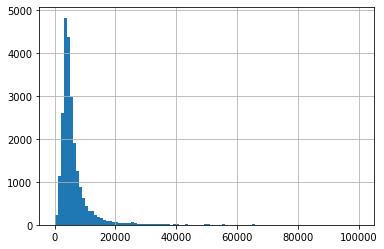

In [45]:
data['last_price'].hist(bins=100, range = (0,100000));

В целом, график приближен к значениям Пуассона. Данные корректны для дальнейшего анализа.

#### Посмотрим подробнее данные о загруженных изображениях (total_images)

In [46]:
data['total_images'].describe()

count    23564.000000
mean         9.878544
std          5.681246
min          0.000000
25%          6.000000
50%          9.000000
75%         14.000000
max         50.000000
Name: total_images, dtype: float64

Сформируем столбчатую диаграмму для оценки.

<AxesSubplot:>

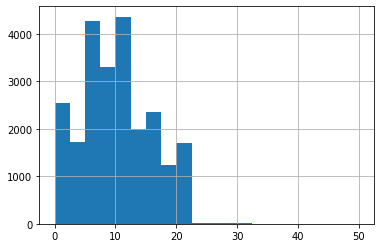

In [47]:
data['total_images'].hist(bins=20)

Медианное значения подгрузки фото - 9 штук. Если рассматривать разрез популярных значений, то в большинстве случаев подгружают от 6 до 14 фото. Максимально возможное значение - 50.

В данных нет пустых значений, медиана близка к среднему значению. Данные пригодны для анализа.

#### Проверим корректность данных о кол-ве дней размещения объявления (days_exposition)

In [48]:
data['days_exposition'].isna().sum()

3171

In [49]:
# data['days_exposition'] = data['days_exposition'].fillna(value=data['days_exposition'].median())

In [50]:
data['days_exposition'].describe()

count    20393.000000
mean       180.749865
std        219.734840
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

Минимальное значение продажи - 1 день, максимальное 1580. 
Пропуск означает, что  квартира не продана. Эти пропуски заполнять или удалять не нужно.

Проверю много ли значений после третьего квартиля, и есть ли аномалии в максимальном знаяении продажи.

<AxesSubplot:>

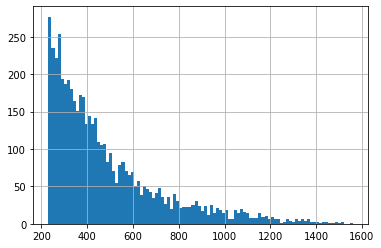

In [51]:
data['days_exposition'].hist(bins=100, range=(231, 1560))

#### Обработаем количественные данные ближайших объектов инфраструктуры (parks_around3000, ponds_around3000)

Выведем пропущенные значения у числа парков в радиусе 3 км и числа водоемов в радиусе 3 км

In [52]:
data['parks_around3000'].isna().sum()

5500

In [53]:
data['ponds_around3000'].isna().sum()

5500

Выведем подсчет уникальных значений у первого и второго.

In [54]:
data['parks_around3000'].value_counts()

0.0    10039
1.0     5646
2.0     1736
3.0      643
Name: parks_around3000, dtype: int64

In [55]:
data['ponds_around3000'].value_counts()

0.0    9028
1.0    5662
2.0    1883
3.0    1491
Name: ponds_around3000, dtype: int64

Что у кол-ва прудов, что и у парков значения распределяются от 0 до 3. Логично предположить, что неуказанные значения эквивалентны 0.
Заменим пустые значения на 0.

In [56]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)

In [57]:
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

Переведем значения этих столбцов из float в int тк они имеют целые числа, и в новом типе нам будет проще производить математичсекие операции в дальнейшем.

In [58]:
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')

#### Обработка значений расстояния до ближайших объектов инфраструктуры (airports_nearest, cityCenters_nearest, parks_nearest, ponds_nearest)

В данных ближайшего аэропора и центра города подозрительно схожие значени:
Группа 1
airports_nearest         5542
cityCenters_nearest      5519

Группа 2
Также как и значения ближайшего парка приближены к значениям ближайшего водоема:
parks_nearest           15620
ponds_nearest           14589

Есть гипотеза, что строки первой группы пересекаются друг с другом и вторая группа аналогично.

Проверим первую Группу 1

In [59]:
len(data.query('airports_nearest.isna() and cityCenters_nearest.isna()'))

5500

Действительно, почти все строки группы пересекаются. Проверим вторую группу.

In [60]:
len(data.query('parks_nearest.isna() and ponds_nearest.isna()'))

11290

Во второй группе пересекается большая часть. Стоит учетсь это в дальнейшем исследовании.
Теперь проверим все переменные на выбросы.

In [61]:
data['airports_nearest'].describe()

count    18040.000000
mean     28796.660089
std      12632.722336
min          0.000000
25%      18563.000000
50%      26756.500000
75%      37273.000000
max      84869.000000
Name: airports_nearest, dtype: float64

In [62]:
data['cityCenters_nearest'].describe()

count    18063.000000
mean     14192.933787
std       8613.505702
min        181.000000
25%       9238.000000
50%      13098.000000
75%      16285.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

In [63]:
data['parks_nearest'].describe()

count    8029.000000
mean      490.541288
std       341.576201
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

In [64]:
data['ponds_nearest'].describe()

count    9036.000000
mean      518.289509
std       278.009558
min        13.000000
25%       293.000000
50%       503.000000
75%       730.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

Аномально максимальных расстояний не наблюдается. Среднее значение приближенно к медианному. 

Чистить исходный датафрейм от пропущенных значений не целесообразно, как и заменять такое кол-вл медианным значением тк будет существенное искажение данных. 

#### Проверим корректность столбца количества комант (rooms)

Выведу количество уникальных значений на экран

In [65]:
data['rooms'].value_counts()

1     8004
2     7896
3     5779
4     1172
5      325
0      194
6      104
7       59
8       12
9        8
10       3
11       2
14       2
19       1
16       1
12       1
15       1
Name: rooms, dtype: int64

In [66]:
len(data.query('rooms == 0'))

194

<AxesSubplot:>

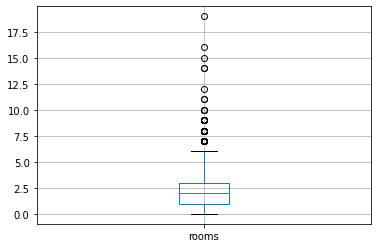

In [67]:
data.boxplot(column='rooms')

Видим выбивающиеся знаяения после 6 комнат. отфильтруем таблицу от этих строк. Также данные с кол-вом комнат 0 тоже дропну, тк они ложные в основной таблице их немного.

In [68]:
data = data.query('8 > rooms > 0')
data['rooms'].value_counts()

1    8004
2    7896
3    5779
4    1172
5     325
6     104
7      59
Name: rooms, dtype: int64

In [69]:
len(data) # проверим длину очищенного датафрейма

23339

#### Вывод

В ходе предобработки данных было сделано:

1. Обработка некорректных данных значения высоты потолков, путем коррекции ошибочных значений и удаления выбросов.
2. Пропущенные строки в столбце с балконом были заменены на 0 (балкон отсутствует)
3. Исправил неявные дубли в названии городов, избавился от пропущенных значений (дропнул все), тк их было не много.
4. Избавился от некорректных значений стоимости жилья (пример: дропнул жилье стоимостью 12 т р)
5. Заменил отсутствующие значение ближайших объектов инфраструктуры на 0 (по логике, если их не указали, значит их нет), перевел в тип INT для удобства расчетов.
6. Почистил данные по комнатам от 0, до квартир с комнатами > 7

После проделанных манипуляций датафрейм насчитывает 23 339 строк, в отличае от стартовых 23 698. Удалено 1,5% данных.

### Посчитайте и добавьте в таблицу новые столбцы

#### Отформатируем столбец с датой и добавим новые столбцы: день недели публикации, месяц, год.

In [70]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')  # изменяем тип даты
data['date_time_weekday'] = pd.DatetimeIndex(data['first_day_exposition']).weekday  # добавляем столбец с днем недели
data['date_time_month'] = pd.DatetimeIndex(data['first_day_exposition']).month  # добавдяем столбец с месяцем публикации
data['date_time_year'] = pd.DatetimeIndex(data['first_day_exposition']).year  # добавляем столбец с годом публикации
data.head()


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,date_time_weekday,date_time_month,date_time_year
0,20,13000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,False,False,25.0,0,санкт-петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,3,3,2019
1,7,3350.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2,поселок шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,1,12,2018
2,10,5196.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0,санкт-петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,3,8,2015
3,0,64900.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0,санкт-петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,4,7,2015
4,2,10000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,False,False,41.0,0,санкт-петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,1,6,2018


#### Добавим столбец со стоимостью квадратного метра

Разделим столбец с ценой на общую жилую площадь и оставим два знака после запятой. Данные запищим в новый столбец.

In [71]:
data['price_for_meter'] = round(data['last_price'] / data['total_area'], 2)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,date_time_weekday,date_time_month,date_time_year,price_for_meter
0,20,13000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,NaN,False,False,25.0,0,санкт-петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,3,3,2019,120.37
1,7,3350.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2,поселок шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,1,12,2018,82.92
2,10,5196.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0,санкт-петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,3,8,2015,92.79
3,0,64900.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0,санкт-петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,4,7,2015,408.18
4,2,10000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,NaN,False,False,41.0,0,санкт-петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,1,6,2018,100.00


#### Посчитаем и добавим в таблицу: расстояние в км до центра города

In [72]:
data['km_to_center'] = round(data['cityCenters_nearest'] / 1000)

#### Посчитаем и добавим в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)

Для корректного расчета переведем floors_total в тип int

In [73]:
data['floors_total'] = data['floors_total'].astype('int')

In [74]:
def floors(row):
    total_info = row['floors_total']
    target_info = row['floor']
    
    if total_info == target_info:
        return 'последний'
    if target_info == 1:
        return 'первый'
    return 'другой'

data['status_floor'] = data.apply(floors, axis=1)

Проверим присвоились ли все значения из функции.

In [75]:
data['status_floor'].value_counts()

другой       17146
последний     3332
первый        2861
Name: status_floor, dtype: int64

In [76]:
data.head()  # выведем 5 строк таблицы

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,date_time_weekday,date_time_month,date_time_year,price_for_meter,km_to_center,status_floor
0,20,13000.0,108.0,2019-03-07,3,2.70,16,51.0,8,NaN,False,False,25.0,0,санкт-петербург,18863.0,16028.0,1,482.0,2,755.0,NaN,3,3,2019,120.37,16.0,другой
1,7,3350.0,40.4,2018-12-04,1,NaN,11,18.6,1,NaN,False,False,11.0,2,поселок шушары,12817.0,18603.0,0,NaN,0,NaN,81.0,1,12,2018,82.92,19.0,первый
2,10,5196.0,56.0,2015-08-20,2,NaN,5,34.3,4,NaN,False,False,8.3,0,санкт-петербург,21741.0,13933.0,1,90.0,2,574.0,558.0,3,8,2015,92.79,14.0,другой
3,0,64900.0,159.0,2015-07-24,3,NaN,14,NaN,9,NaN,False,False,NaN,0,санкт-петербург,28098.0,6800.0,2,84.0,3,234.0,424.0,4,7,2015,408.18,7.0,другой
4,2,10000.0,100.0,2018-06-19,2,3.03,14,32.0,13,NaN,False,False,41.0,0,санкт-петербург,31856.0,8098.0,2,112.0,1,48.0,121.0,1,6,2018,100.00,8.0,другой


#### Вывод

На данном этапе работы мы добавили 6 стобцов: 5 из них с количесвтенной переменной, один с категориальной. 

В столбце date_time_weekday указан день недели публикации объявления (0 — понедельник, 1 — вторник и так далее).

Столбец date_time_month отвечает за номер месяца в календарном значении, а date_time_year - год публикации объявления.

price_for_meter содержит значения стоимости позиции жилья за квадратный метр исходя из общей площади квартиры и стоимости жилья.

Переменная km_to_center отвечающая за расстояние до центра содержит расстояние в км округленное в ближайшую сторону к целому числу.

Категориальная переменная status_floor содержит информацию по этажности продавайемой позиции: тип этажа квартиры (значения — «первый», «последний», «другой»).

### Проведите исследовательский анализ данных

Изучим общую информацию по следующим параметрам:
  - общая площадь;
  - жилая площадь;
  - площадь кухни;
  - цена объекта;
  - количество комнат;
  - высота потолков;
  - этаж квартиры;
  - тип этажа квартиры («первый», «последний», «другой»);
  - общее количество этажей в доме;
  - расстояние до центра города в метрах;
  - расстояние до ближайшего аэропорта;
  - расстояние до ближайшего парка;
  - день и месяц публикации объявления

In [77]:
top_data = data[['last_price', 'total_area','living_area', 'kitchen_area', 'rooms', 
                 'ceiling_height', 'floor', 'floors_total', 'cityCenters_nearest', 'airports_nearest',
                 'parks_nearest', 'date_time_weekday', 'date_time_month'
                ]]
top_data.head()

,last_price,total_area,living_area,kitchen_area,rooms,ceiling_height,floor,floors_total,cityCenters_nearest,airports_nearest,parks_nearest,date_time_weekday,date_time_month
0,13000.0,108.0,51.0,25.0,3,2.70,8,16,16028.0,18863.0,482.0,3,3
1,3350.0,40.4,18.6,11.0,1,NaN,1,11,18603.0,12817.0,NaN,1,12
2,5196.0,56.0,34.3,8.3,2,NaN,4,5,13933.0,21741.0,90.0,3,8
3,64900.0,159.0,NaN,NaN,3,NaN,9,14,6800.0,28098.0,84.0,4,7
4,10000.0,100.0,32.0,41.0,2,3.03,13,14,8098.0,31856.0,112.0,1,6


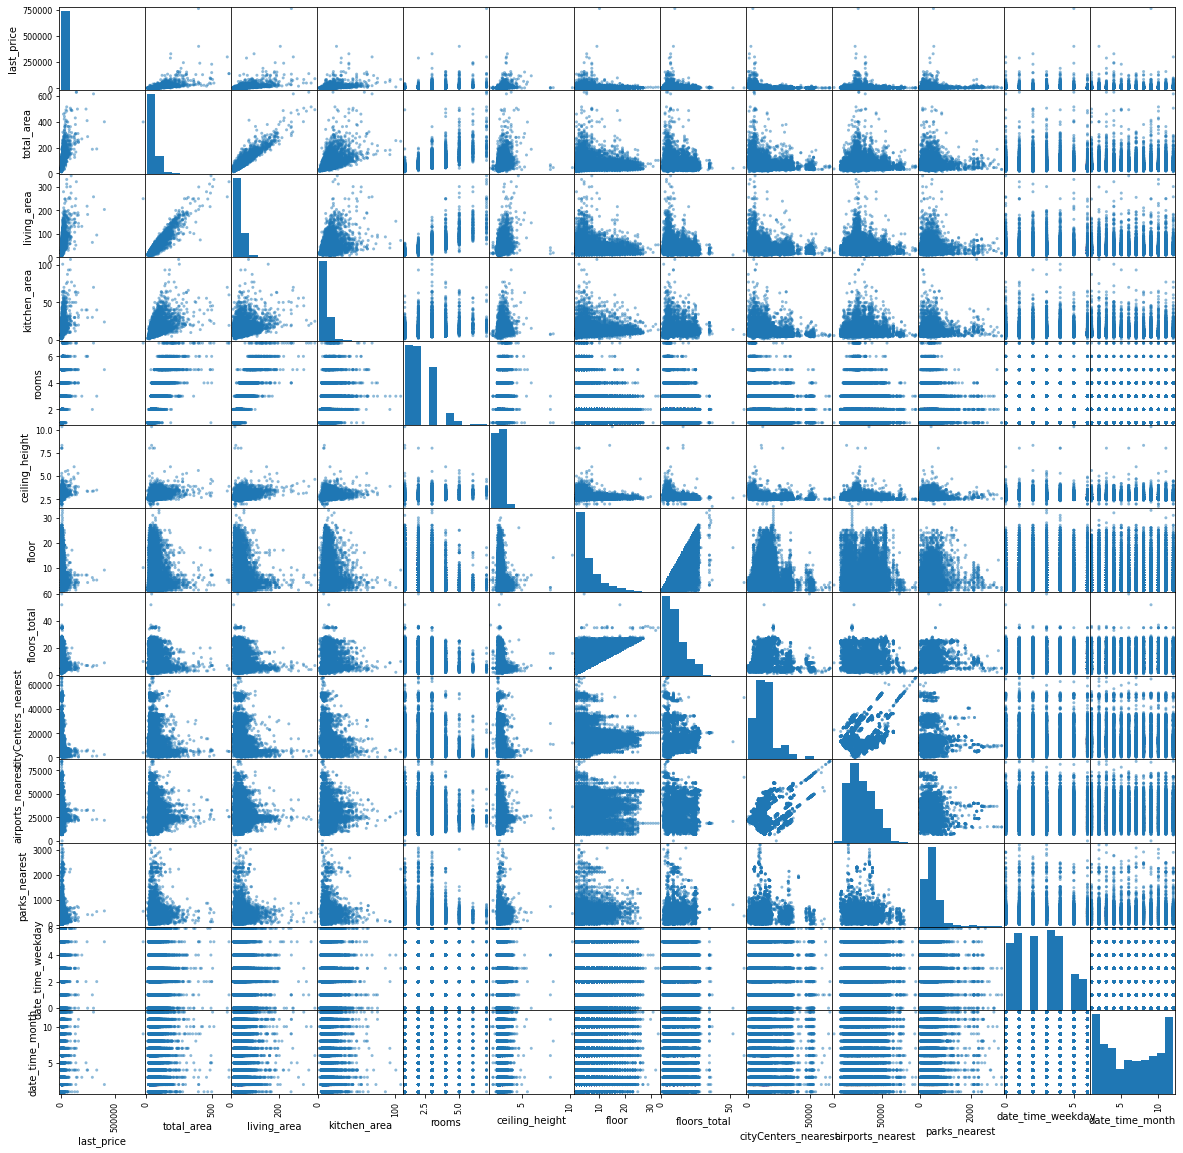

In [78]:
 pd.plotting.scatter_matrix(top_data, figsize=(20,20));

На графиках мы видим некоторые зависимости по Пирсону, посмотрим их подробнее через таблицу.

In [79]:
top_data.corr()

,last_price,total_area,living_area,kitchen_area,rooms,ceiling_height,floor,floors_total,cityCenters_nearest,airports_nearest,parks_nearest,date_time_weekday,date_time_month
last_price,1.000000,0.641649,0.552241,0.506734,0.352324,0.392437,0.024908,-0.004695,-0.211270,-0.026941,-0.016177,0.002555,0.002056
total_area,0.641649,1.000000,0.937119,0.597249,0.750348,0.458344,-0.021665,-0.066873,-0.234633,-0.030370,-0.022945,-0.004832,0.008579
living_area,0.552241,0.937119,1.000000,0.407581,0.843455,0.429266,-0.097273,-0.166042,-0.232501,-0.057542,-0.051997,-0.005244,0.001928
kitchen_area,0.506734,0.597249,0.407581,1.000000,0.251645,0.404928,0.136763,0.168410,-0.191454,0.009075,0.027670,-0.008232,0.003608
rooms,0.352324,0.750348,0.843455,0.251645,1.000000,0.274478,-0.149662,-0.220443,-0.185862,-0.064188,-0.055099,-0.003640,0.002310
ceiling_height,0.392437,0.458344,0.429266,0.404928,0.274478,1.000000,-0.039978,-0.084409,-0.339215,-0.096388,-0.054209,-0.015254,0.005310
floor,0.024908,-0.021665,-0.097273,0.136763,-0.149662,-0.039978,1.000000,0.678806,0.007091,0.076007,0.071471,0.011061,0.019911
floors_total,-0.004695,-0.066873,-0.166042,0.168410,-0.220443,-0.084409,0.678806,1.000000,0.016529,0.110588,0.094923,0.012085,0.015483
cityCenters_nearest,-0.211270,-0.234633,-0.232501,-0.191454,-0.185862,-0.339215,0.007091,0.016529,1.000000,0.272070,-0.041493,0.009188,-0.010100
airports_nearest,-0.026941,-0.030370,-0.057542,0.009075,-0.064188,-0.096388,0.076007,0.110588,0.272070,1.000000,-0.071483,0.002804,0.006914


Числовую взаимосвязь оценим с помощью коэффициента корреляции Пирсона. Выгрузив общие данные, можно сделать следующие выводы:
1. Больше всего стоимость жилья зависит от общей площади (коэф 0,64), жилой площади (коэф 0,55) и площади кухни (коэф 0,5). Чем больше площадь, тем выше стоимость.
2. Стоимость жилья в представленном массиве данных не зависит от близкого расположения парка/аэропорта (коэф -0,01/-0.02)
3. Средняя зависимость цены на квартиру наблюдается в корреляции с расположением квартиры ближе к центру, количеством комнат, высотой потолков (коэф от 0,21 до 0,39)

#### Общая площадь

In [80]:
data['total_area'].describe()

count    23339.000000
mean        60.253303
std         34.133108
min         12.000000
25%         40.100000
50%         52.000000
75%         70.000000
max        631.200000
Name: total_area, dtype: float64

75% общего массива данных - это квартиры площадью до 70 кв м. Медианная общая площадь представленных квартир 52 кв м.
Минимальная площадь - 12 кв м, что для питерских квартир вполне реально.

Построим диаграмму рассеивания для определения потенциальных взаимосвязей между количественными переменными

(0.0, 70000.0)

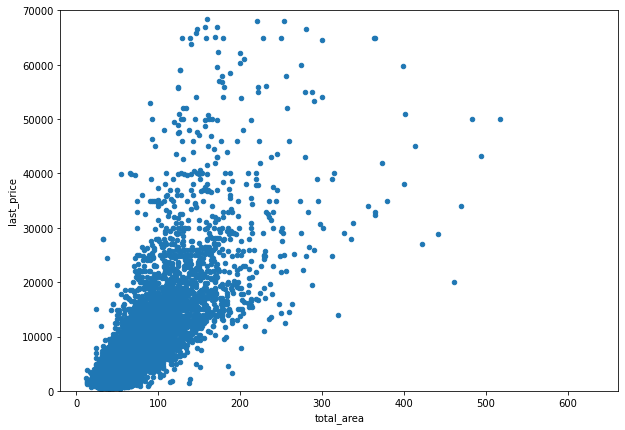

In [81]:
data.plot(x='total_area', y='last_price', kind='scatter', figsize=(10,7));
plt.ylim(0, 70000)

In [82]:
data['last_price'].corr(data['total_area'])

0.64164898246544

Зависимость стоимости от общей полощади квартиры прямая: при увеличении общей площади растет и цена (коэф Пирсона 0,64). 
Значения после стоимости 30 млн достаточно рассеяны, видимо в элитной недвижимости этот фактор играет меньшую роль.

#### Жилая площадь

In [83]:
data['living_area'].describe()

count    21486.000000
mean        34.374262
std         21.131793
min          8.000000
25%         18.700000
50%         30.000000
75%         42.400000
max        347.500000
Name: living_area, dtype: float64

(0.0, 70000.0)

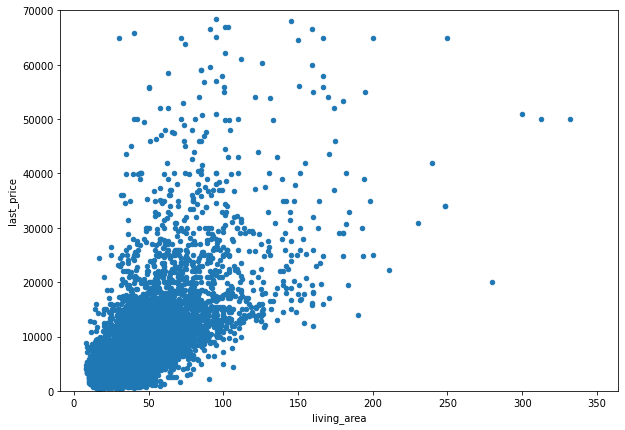

In [84]:
data.plot(x='living_area', y='last_price', kind='scatter', figsize=(10,7))
plt.ylim(0, 70000)

In [85]:
data['last_price'].corr(data['living_area'])

0.552240624419112

С жилой площадью ситуация обстоит также. Прослеживается прямая зависимость роста стоимости жилья при увеличении жилой площади (коэф 0,55).

#### Площадь кухни

In [86]:
data['kitchen_area'].describe()

count    21315.000000
mean        10.535989
std          5.798160
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        107.000000
Name: kitchen_area, dtype: float64

(0.0, 70000.0)

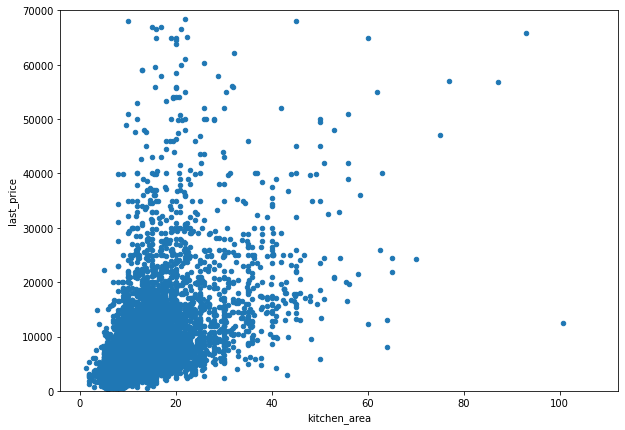

In [87]:
data.plot(x='kitchen_area', y='last_price', kind='scatter', figsize=(10,7));
plt.ylim(0, 70000)

In [88]:
data['last_price'].corr(data['kitchen_area'])

0.5067339360863476

Так как площадь кухни зачастую зависит от общей и жилой, ситуацию мы видим схожую, но немного в меньшей степени (коэф 0,50)

#### Цена объекта

In [89]:
data['last_price'].describe()

count     23339.000000
mean       6506.847387
std       10457.269492
min         430.000000
25%        3450.000000
50%        4650.000000
75%        6800.000000
max      763000.000000
Name: last_price, dtype: float64

Средняя стоимость для квартиры из датасета составляет 6 млн 500 тыс рублей, что достаточно искажает информацию за счет большого разброса минимального и максимального значения. Оценить лучше по медиане, которая составляет 4 млн 650 тысяч.

<AxesSubplot:>

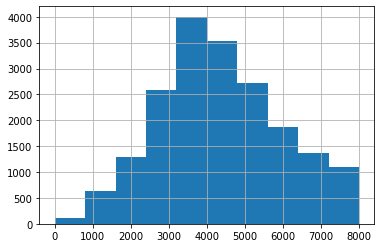

In [90]:
data['last_price'].hist(range=(0,8000))  # выведу гистограмму до 3 квартиля

Гистограмма распредлена в значениях Пуассона и отражает корректные данные датасета.

#### Количество комнат

In [91]:
data['rooms'].describe()

count    23339.000000
mean         2.077338
std          1.022403
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          7.000000
Name: rooms, dtype: float64

<AxesSubplot:>

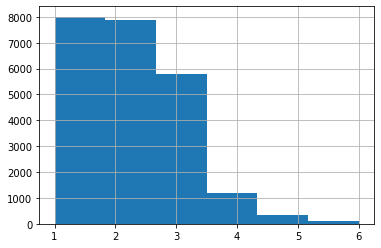

In [92]:
data['rooms'].hist(bins=6, range=(1,6))

Медианное значения по кол-ву комнат совпадает со средним. Максимальное значение - 7. Преимущественно в датасете представлены квартиры до 3 комнат включительно. На графике представлено распределение значений.

In [93]:
data['last_price'].corr(data['rooms'])

0.3523235330371241

Зависимость стоимости жилья от кол-ва комнат в квартире прослеживается по Пирсону в умеренном значении 0,35, то есть, как правило чем больше комант в квартире, тем выше цена.

#### Высота потолков

In [94]:
data['ceiling_height'].describe()

count    14372.000000
mean         2.727044
std          0.297847
min          1.750000
25%          2.507500
50%          2.650000
75%          2.800000
max         10.300000
Name: ceiling_height, dtype: float64

<AxesSubplot:>

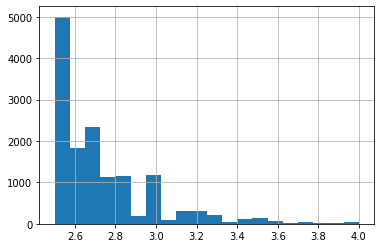

In [95]:
data['ceiling_height'].hist(bins=20, range=(2.5,4))

Среднее значение высоты потолков приближено к медианому - 2,65-2,72. Основной массив данных - квартиры с потолком до 2,80. На графике представлено распределение количественных значений.

#### Этаж квартиры

In [96]:
data['floor'].describe()

count    23339.000000
mean         5.857192
std          4.850711
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

<AxesSubplot:>

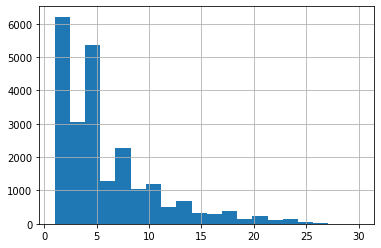

In [97]:
data['floor'].hist(bins=20, range=(1, 30)) # построим график распределения этажей квартир в датасете

75% датасета - это квартиры, расположенные до 8 этажа. Среднее значение 5,85, медианное - 4. 

#### Тип этажа квартиры («первый», «последний», «другой»)

In [98]:
data['status_floor'].value_counts()

другой       17146
последний     3332
первый        2861
Name: status_floor, dtype: int64

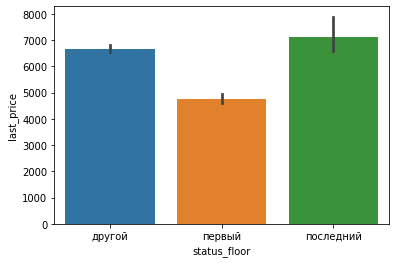

In [99]:
sns.barplot(x='status_floor', y='last_price', data=data);


Мы видим, что средеяя стоимость по первому этажу  отстает. Проверим медиану по каждому, чтобы убедиться, что первый этаж в среднем дешевле, чем любой другой.

In [100]:
price_floor = data.pivot_table(index='status_floor', values='last_price', aggfunc=('median'))
price_floor

,last_price
status_floor,
другой,4850.0
первый,3900.0
последний,4300.0


Действительно, первый этаж в медианном значении стоит 3 млн 900 тыс рублей, любой другой - 4 млн 850 тыс рублей, последний - 4 млн 300 тыс рублей.
Первый этаж самый дешевый.

#### Общее количество этажей в доме

In [101]:
data['floors_total'].describe()

count    23339.000000
mean        10.629890
std          6.567712
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

In [102]:
data['last_price'].corr(data['floors_total'])

-0.004694736700711482

Медианное значение общего кол-ва этажей в доме составляет 9 этажей. Основной массив данных - дома с этажностью до 16. 
Корреляция между стоимостью жилья и кол-вом этажей в доме не прослеживается.

#### Расстояния до центра города, ближайшего аэропорта и парка;

In [103]:
data['cityCenters_nearest'].describe() # расстояние до центра

count    17915.000000
mean     14211.186324
std       8629.714719
min        181.000000
25%       9252.000000
50%      13101.000000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

In [104]:
data['airports_nearest'].describe() # расстояние до аэропорта

count    17892.000000
mean     28834.000671
std      12635.100057
min          0.000000
25%      18578.000000
50%      26786.000000
75%      37310.000000
max      84869.000000
Name: airports_nearest, dtype: float64

In [105]:
data['parks_nearest'].describe() # расстояние до парка

count    7975.000000
mean      490.280502
std       341.708166
min         1.000000
25%       288.000000
50%       454.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

Усредненная квартира по датасету находится в 13 км от центра и 26 км от аэропорта. Ближайший парк находится на расстоянии примерно 0,45 км.

(0.0, 70000.0)

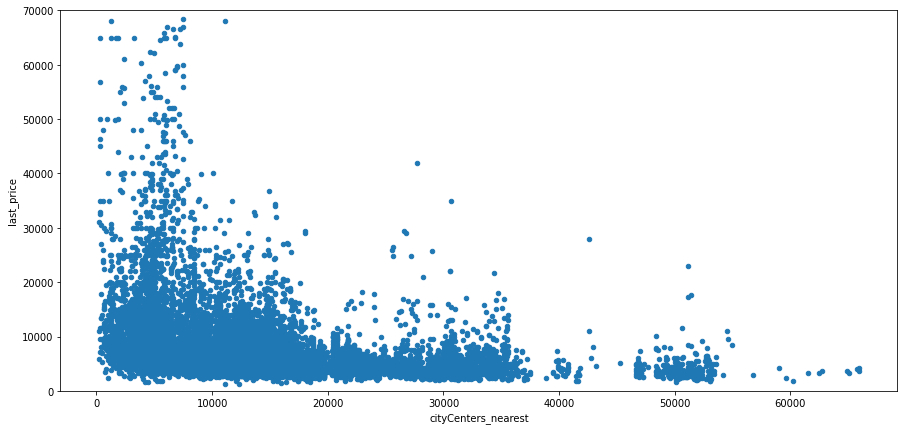

In [106]:
data.plot(x='cityCenters_nearest', y='last_price', kind='scatter', figsize=(15,7));
plt.ylim(0, 70000)

In [107]:
data['last_price'].corr(data['cityCenters_nearest'])

-0.21126967673392466

(0.0, 70000.0)

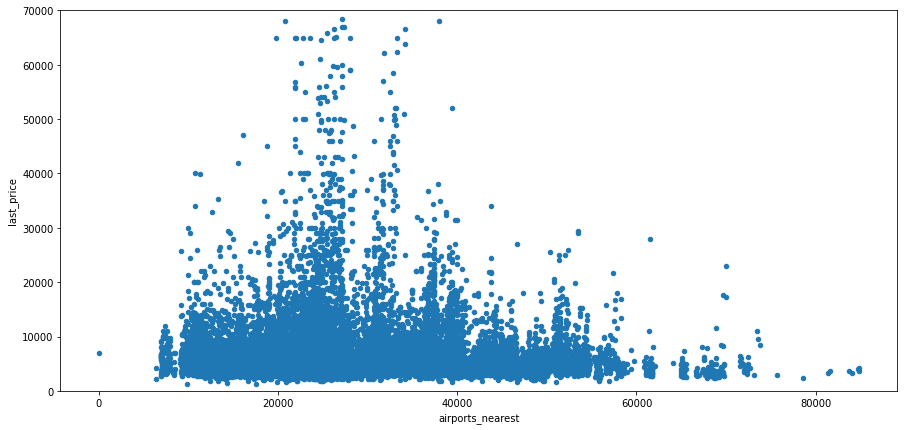

In [108]:
data.plot(x='airports_nearest', y='last_price', kind='scatter', figsize=(15,7));
plt.ylim(0, 70000)

In [109]:
data['last_price'].corr(data['airports_nearest'])

-0.026941447327903295

(0.0, 70000.0)

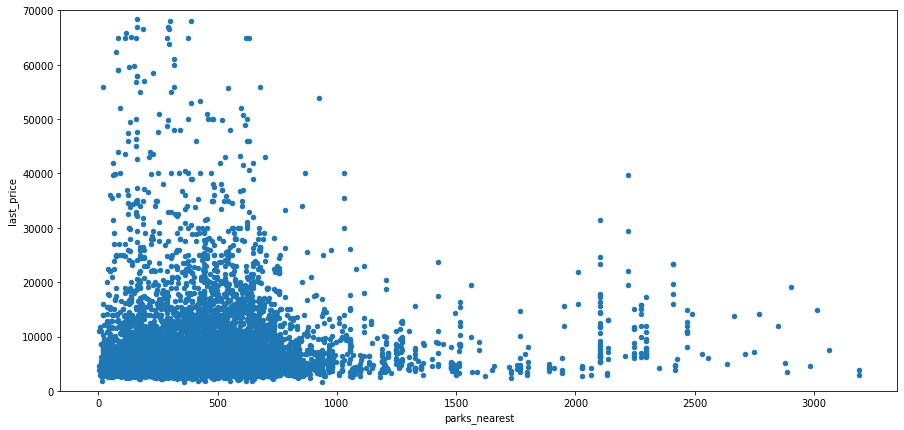

In [110]:
data.plot(x='parks_nearest', y='last_price', kind='scatter', figsize=(15,7));
plt.ylim(0, 70000)

In [111]:
data['last_price'].corr(data['parks_nearest'])

-0.01617651981496378

Больше всего из объектов инфраструктуры на ценообразование влияет расположение квартиры ближе к центру города. Коэф по Пирсону 0,21 против -0,01/-0,02 у других объектов.

#### День, месяц, год публикации объявления

In [112]:
data['date_time_weekday'].describe() # день недели

count    23339.000000
mean         2.566434
std          1.789575
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: date_time_weekday, dtype: float64

In [113]:
day_data = data.pivot_table(index='date_time_weekday', values = 'last_price', aggfunc=('count'))
day_data

,last_price
date_time_weekday,
0,3572
1,4122
2,3910
3,4229
4,3932
5,1903
6,1671


In [114]:
day_data['date_time_weekday'] = day_data.index.values

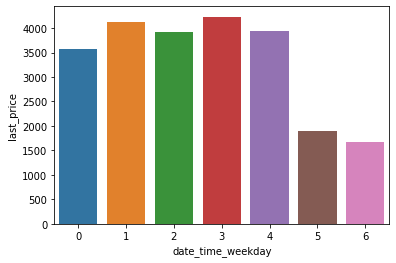

In [115]:
sns.barplot(x='date_time_weekday', y='last_price', data=day_data);

Наименьшее кол-во публикаций объявлений приходится на выходные дни (суббота/воскресенье).

##### Проведем исследование месяцев публикации объявления

Построим график распределения средней стоимости жилья на каждый месяц.

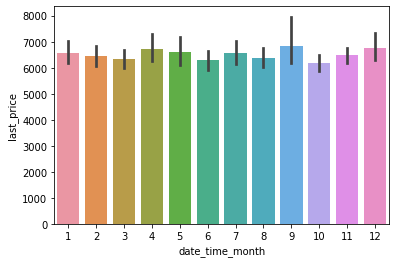

In [116]:
sns.barplot(x='date_time_month', y='last_price', data=data);

Видно что средняя цена в зависимости от месяца публикации не меняется. То есть черной пятницы недвижимости в течение года никто не устраивает. 

Но нас больше инетересует кол-во объявлений, публикуемых в каждый месяц. Построим сводную таблицу.

In [117]:
month_data = data.pivot_table(index='date_time_month', values = 'last_price', aggfunc=('count'))
month_data

,last_price
date_time_month,
1,1472
2,2612
3,2553
4,2338
5,1253
6,1741
7,1664
8,1718
9,1947


In [118]:
month_data['date_time_month'] = month_data.index.values

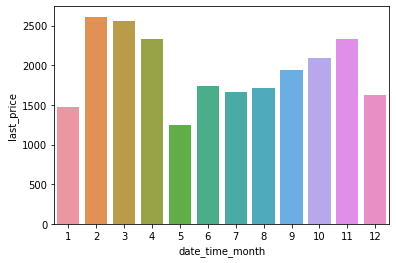

In [119]:
sns.barplot(x='date_time_month', y='last_price', data=month_data);

Меньше всего публикаций новых объявлений в течение года приходятся на январь, и май. Максимальные значения публикаций - февраль, март. К лету обьем предложений уменьшается и стагнирует до конца лета. Локальный рост график показывает с сентября по ноябрь (время после летних каникул).

##### Построим график зависимости стоимости жилья от года публикации.

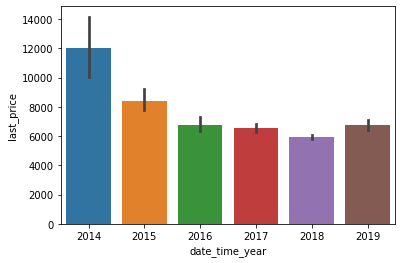

In [120]:
sns.barplot(x='date_time_year', y='last_price', data=data);

Видно, что средняя цена недвижимости в 2014 году была самой высокой. С 2015 года средняя стоимость пошла на спад и начала свой рост в 2019 году. Проверим медианные значения, чтобы исключить влияние сверхдорогого жилья. Построим боксплот для каждого года.

(0.0, 15000.0)

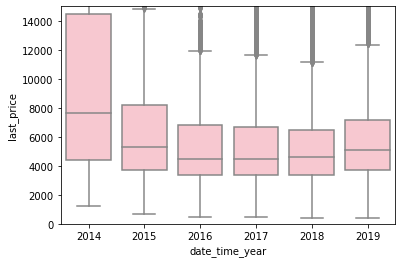

In [121]:
sns.boxplot(
    x='date_time_year', 
    y='last_price', 
    data=data, 
    color='pink')
plt.ylim(0, 15000)

Выгрузим сводную таблицу по годам с медианным значением.

In [122]:
year_data = data.pivot_table(index='date_time_year', values = 'last_price', aggfunc=('median'))
year_data

,last_price
date_time_year,
2014,7640.0
2015,5300.0
2016,4500.0
2017,4500.0
2018,4600.0
2019,5100.0


Информация подтверждается. Медианная цена недвижимости в 2014 году также была самой высокой. С 2015 года был резкий спад, стогнация в 2016-17 годах и коррекция вверх начиная с 2018 года.

75% всех объявлений размещаются в будние дни. 

Меньше всего публикаций новых объявлений в течение года приходятся на январь и май. Максимальные значения публикаций - февраль, март. К лету обьем предложений уменьшается и стагнирует до конца лета. Локальный рост объем публикуемых объявлений показывает с сентября по ноябрь (время после летних каникул). 

Медианная цена недвижимости в 2014 году была самой высокой. С 2015 года был резкий спад, стогнация в 2016-17 годах и коррекция вверх начиная с 2018 года.


#### Дни размещения объявления (от публикации до снятия)

In [123]:
data['days_exposition'].describe()

count    20189.000000
mean       181.138491
std        219.764979
min          1.000000
25%         45.000000
50%         96.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

(70.0, 800.0)

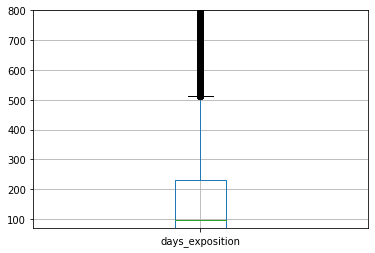

In [124]:
data.boxplot(column='days_exposition')
plt.ylim(70, 800)

##### 95 дней обычно занимает продажа. Это медиана полученных значений. 
Продажи меньше первого квартиля (45 дней) можно считать быстрыми, необычно долгие продажи - это продажи дольше 500 дней (верхний ус - граница выбросов).

<AxesSubplot:>

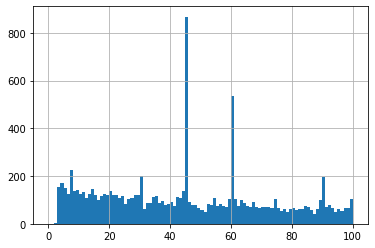

In [125]:
data['days_exposition'].hist(bins=100, range=(0, 100))

#### Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра. 

In [126]:
data.value_counts('locality_name').head(10) # выведем топ 10 городов по размещенным объявлениям

locality_name
санкт-петербург      15511
поселок мурино         526
поселок шушары         435
всеволожск             392
пушкин                 369
колпино                337
поселок парголово      323
гатчина                307
деревня кудрово        283
выборг                 237
dtype: int64

Выгрузим в отдельный датафрейм данные по топ городам.

In [127]:
filter_top_local = ['санкт-петербург', 'поселок мурино', 'поселок шушары', 'всеволожск', 'пушкин', 'колпино', 'поселок парголово', 'гатчина', 'деревня кудрово', 'выборг']
top_local = data.query('locality_name.isin(@filter_top_local)')

In [128]:
top_local_data = top_local.pivot_table(index='locality_name', values='price_for_meter', aggfunc=('mean'))
top_local_data.sort_values(by='price_for_meter') # выгрузим сводную таблицу по

,price_for_meter
locality_name,
выборг,58.141941
всеволожск,68.618010
гатчина,68.746319
колпино,75.333175
поселок шушары,78.278161
поселок мурино,85.029582
поселок парголово,90.290062
деревня кудрово,92.297385
пушкин,103.125854


Мы посчитали среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. 
Населённые пункты с самой высокой стоимостью квадратного метра: Санкт-Петербург, Пушкин.
Населённые пункты с самой низкой стоимостью квадратного метра: Выборг, Всеволжск, Гатчина.

#### Вычислим среднюю цену каждого километра в Санкт-Петербурге 

In [129]:
filter_spb = data.query('locality_name == "санкт-петербург"')
filter_spb = filter_spb[['last_price', 'km_to_center']]
filter_spb_data = filter_spb.pivot_table(index='km_to_center', values='last_price', aggfunc=('mean'))
filter_spb_data.head(10)

,last_price
km_to_center,
0.0,31449.115852
1.0,21207.938619
2.0,17800.395000
3.0,10919.458988
4.0,13026.927363
5.0,14368.933621
6.0,15099.775966
7.0,14830.225086
8.0,9183.507966


<AxesSubplot:xlabel='km_to_center'>

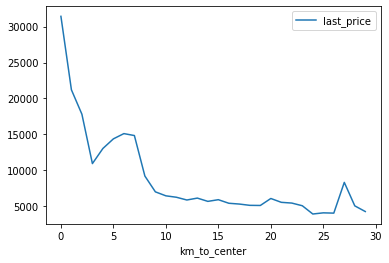

In [130]:
filter_spb_data.plot()

В сводной таблице выведена средняя цена за каждый км. 
Стоимость объектов существенно снижается в зависимости от удаленности до центра города.
Есть некоторые пики на грифике, но, полагаю, они связаны с наличием элитных районов/застроек в срезе данного км.

### Общий вывод

75% общего массива данных - это квартиры площадью до 70 кв м. Медианная площадь представленных квартир 52 кв м.
Минимальная площадь - 12 кв м, что для питерских квартир вполне реально. Усредненная квартира по датасету находится в 13 км от центра и 26 км от аэропорта. Ближайший парк находится на расстоянии примерно 0,45 км. Среднее-медианное значение высоты потолков - 2,65-2,72. Основной массив данных - квартиры с потолком до 2,80.

Зависимость стоимости квартиры от ее общей полощади прямая: при увеличении общей площади растет и цена (коэф Пирсона 0,64). 
Значения после стоимости 30 млн достаточно рассеяны, видимо в элитной недвижимости этот фактор играет меньшую роль. С жилой площадью ситуация обстоит также. Прослеживается прямая зависимость роста стоимости жилья при увеличении жилой площади (коэф 0,55).
Так как площадь кухни зачастую зависит от общей и жилой, ситуацию мы видим схожую, но в меньшей степени (коэф 0,5). Зависимость стоимости жилья от кол-ва комнат в квартире прослеживается по Пирсону в умеренном значении 0,35, то есть, как правило чем больше комант в квартире, тем выше цена.

Изучив данные по этажности выявлено, что первый этаж в медианном значении (первотэтажок) стоит 3 млн 900 тыс рублей, любой другой - 4 млн 850 тыс рублей, последний - 4 млн 300 тыс рублей. Первый этаж самый дешевый.

Продажа в среднем занимает 95 дней. Это медиана полученных значений. Продажи меньше первого квартиля (45 дней) можно считать быстрыми, необычно долгие продажи - это продажи дольше 500 дней (верхний ус - граница выбросов).

Больше всего из объектов инфраструктуры на ценообразование влияет расположение квартиры ближе к центру города. Коэф по Пирсону 0,21 против -0,01/-0,02 у других объектов. Да, этот коэф не большой, но, рассмотрев срез по Санкт-Петербургу, на графике из п.4.14, после группировки по средней стоимости за км от центра, мы видим системную зависимость этого фактора: стоимость км существенно снижается в зависимости от удаленности от центра города.

Посчитав среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений, были выделены населённые пункты с самой высокой стоимостью квадратного метра: Санкт-Петербург, Пушкин. Населённые пункты с самой низкой стоимостью квадратного метра: Выборг, Всеволжск, Гатчина.

75% всех объявлений размещаются в будние дни. 
Меньше всего публикаций новых объявлений в течение года приходятся на январь и май. Максимальные значения публикаций - февраль, март. К лету обьем предложений уменьшается и стагнирует до конца лета. Локальный рост объем публикуемых объявлений показывает с сентября по ноябрь (время после летних каникул). 
Медианная цена недвижимости в 2014 году была самой высокой. С 2015 года был резкий спад, стогнация в 2016-17 годах и коррекция вверх начиная с 2018 года.